<a href="https://colab.research.google.com/github/AdrienBolling/reconnaissance-echiquiers/blob/main/occupancy_classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from tensorflow.keras import layers


folder = '/content/drive/MyDrive/dataset'
image_size = (224, 224)
batch_size = 32

In [3]:
train_img = tf.keras.utils.image_dataset_from_directory(
    folder + '/train',
    labels = 'inferred',
    image_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb',
    shuffle=True  
)
test_img = tf.keras.utils.image_dataset_from_directory(
    folder+'/test',
    labels = 'inferred',
    image_size = image_size,
    batch_size = batch_size,
    color_mode = 'rgb',
    shuffle=False 
)

Found 3620 files belonging to 2 classes.
Found 906 files belonging to 2 classes.


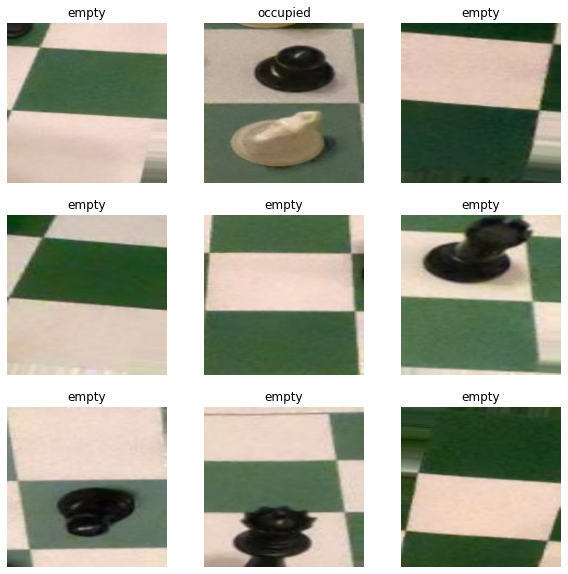

In [4]:
import matplotlib.pyplot as plt

class_names = train_img.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_img.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## data augmentation and classification

In [5]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=5,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(
    folder + '/train',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True)
test_gen = test_datagen.flow_from_directory(
    folder + '/test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False)

Found 3620 images belonging to 2 classes.
Found 906 images belonging to 2 classes.


In [6]:
from keras.applications.vgg16 import VGG16
model1 = VGG16(weights='imagenet',include_top = False,classifier_activation= 'sodtmax')
model1.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers from VGG16
for layer in base_model.layers:
    layer.trainable = False
# Establish new fully connected block
x = base_model.output
x = Flatten()(x) 
x = Dense(500, activation='relu')(x) 
x = Dense(500, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [12]:
epochs = 10
history = model.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen)
model.save_weights('model_VGG16.h5')

Epoch 1/10
114/114 [==============================] - 446s 4s/step - loss: 0.0186 - categorical_accuracy: 0.9925 - val_loss: 0.0134 - val_categorical_accuracy: 0.9967
Epoch 2/10
114/114 [==============================] - 53s 464ms/step - loss: 0.0017 - categorical_accuracy: 0.9994 - val_loss: 0.0059 - val_categorical_accuracy: 0.9967
Epoch 3/10
114/114 [==============================] - 53s 463ms/step - loss: 0.0018 - categorical_accuracy: 0.9994 - val_loss: 0.0107 - val_categorical_accuracy: 0.9967
Epoch 4/10
114/114 [==============================] - 51s 451ms/step - loss: 0.0031 - categorical_accuracy: 0.9989 - val_loss: 0.0184 - val_categorical_accuracy: 0.9945
Epoch 5/10
114/114 [==============================] - 52s 459ms/step - loss: 0.0019 - categorical_accuracy: 0.9994 - val_loss: 0.0124 - val_categorical_accuracy: 0.9967
Epoch 6/10
114/114 [==============================] - 53s 464ms/step - loss: 0.0040 - categorical_accuracy: 0.9989 - val_loss: 0.0157 - val_categorical_accur

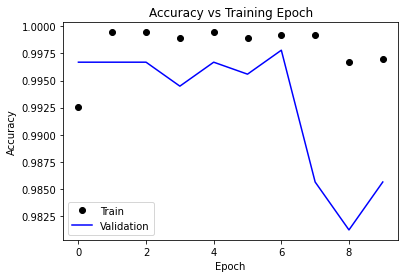

In [13]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

29/29 [==============================] - 4s 122ms/step
False


<ipython-input-19-b18283b18248>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print((y_pred==target_names))


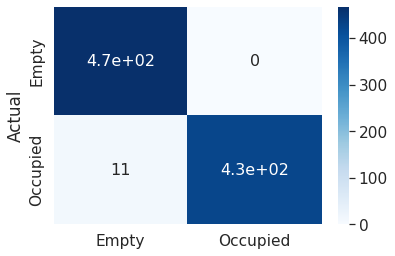

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['Empty', 'Occupied']

Y_pred = model.predict(test_img)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print((y_pred==target_names))


data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [18]:
print('Confusion Matrix')
print(data)
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

Confusion Matrix
[[467   0]
 [ 11 428]]
Classification Report
              precision    recall  f1-score   support

       Empty       0.98      1.00      0.99       467
    Occupied       1.00      0.97      0.99       439

    accuracy                           0.99       906
   macro avg       0.99      0.99      0.99       906
weighted avg       0.99      0.99      0.99       906

